In [35]:
from dgl.data import *
from dgl import edge_homophily, node_homophily
import torch
import numpy as np
from sklearn.neighbors import kneighbors_graph

import matplotlib.pyplot as plt
import seaborn as sns

import pickle

from arch import *

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
assert torch.cuda.is_available()

In [3]:
dataset = TexasDataset()#CoraGraphDataset()
graph = dataset[0]

Done loading data from cached files.


In [4]:
N = graph.number_of_nodes()
n_classes = dataset.num_classes

X = graph.ndata['feat'].to(device)
Y = graph.ndata['label'].to(device)
train_idx = graph.ndata['train_mask'].to(device)
val_idx = graph.ndata['val_mask'].to(device)
test_idx = graph.ndata['test_mask'].to(device)

In [5]:
if train_idx.ndim > 1:
    train_idx = train_idx[:,0]
    val_idx = val_idx[:,0]
    test_idx = test_idx[:,0]

In [6]:
A = graph.adj().to_dense().to(device)
g = graph.clone().to(device)

In [7]:
edge_homophily(g, Y), node_homophily(g, Y)

(0.10769230872392654, 0.10370904952287674)

In [8]:
A_np = graph.adj().to_dense().numpy()
F = compute_features(A_np, "role")
A_knn = kneighbors_graph(F, 3).todense()
A_knn_torch = torch.from_numpy(A_knn.copy()).to(device).float()
g_knn = dgl.from_networkx(nx.from_numpy_array(A_knn)).to(device)#.add_self_loop()

In [9]:
edge_homophily(g_knn, Y), node_homophily(g_knn, Y)

(0.5539215803146362, 0.5440359115600586)

In [10]:
g = g.add_self_loop()
g_knn = g_knn.add_self_loop()

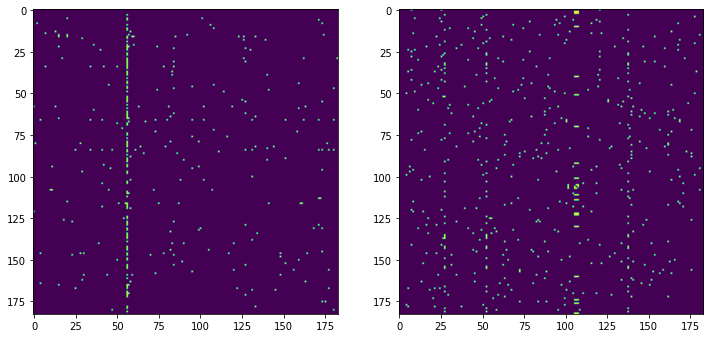

In [11]:
f, ax = plt.subplots(1,2,figsize=(12,8))
ax[0].imshow(A_np)
ax[1].imshow(A_knn)

In [12]:
L = torch.diag(A.sum(1)) - A
L_knn = torch.diag(A_knn_torch.sum(1)) - A_knn_torch

Yf = Y.clone().float()
Yf @ L @ Yf, Yf @ L_knn @ Yf

(tensor(1392., device='cuda:0'), tensor(581., device='cuda:0'))

# Neural Network

In [13]:
lr = 5e-3
wd = 5e-4
n_epochs = 500
n_layers = 2
hid_dim = 32
K = 2
eval_freq = 20

nonlin = nn.ReLU()
last_act = nn.Identity()
dropout = 0.25

In [14]:
in_dim = X.shape[1]
out_dim = n_classes

In [15]:
def test(model, x, y, train_idx, val_idx, test_idx, graph=None, es_patience=100, verbose=True):

    opt = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=wd)

    loss_fn = nn.CrossEntropyLoss()

    losses, acc_train, acc_val, acc_test = [np.zeros(n_epochs) for _ in range(4)]

    best_acc_val = 0.
    best_epoch = 0.
    count_es = 0

    for i in range(n_epochs):
        model.train()
        y_hat = model(graph, x)
        loss = loss_fn(y_hat[train_idx], y[train_idx])

        opt.zero_grad()
        loss.backward()
        opt.step()

        model.eval()
        with torch.no_grad():
            y_hat = model(graph, x)

            preds = torch.argmax(y_hat, 1)
            results = (preds == y).type(torch.float32)
            acc_train[i] = results[train_idx].mean().item()
            acc_val[i] = results[val_idx].mean().item()
            acc_test[i] = results[test_idx].mean().item()

        if acc_val[i] > best_acc_val:
            best_acc_val = acc_val[i]
            best_epoch = i
            count_es = 0
        else:
            count_es += 1

        if es_patience > 0 and count_es == es_patience:
            break

        losses[i] = loss.item()

        if (i == 0 or (i+1) % eval_freq == 0) and verbose:
            print(f"Epoch {i+1}/{n_epochs} - Loss: {losses[i]} - Train Acc: {acc_train[i]} - Test Acc: {acc_test[i]}", flush=True)

    return losses, acc_train, acc_val, acc_test, acc_test[best_epoch]

In [16]:
gcn_kwargs = {'norm': 'both'}
gcn_model = GCN(in_dim, hid_dim, out_dim, n_layers, nonlin=nonlin, last_act=nn.Identity(), dropout=dropout, gcnlayer=dgl.nn.GraphConv, gcnlayer_kwargs=gcn_kwargs).to(device)
loss_train_gcn_orig, acc_train_gcn_orig, acc_val_gcn_orig, acc_test_gcn_orig, best_acc_test_gcn_orig =\
    test(gcn_model, X, Y, train_idx, val_idx, test_idx, g)

Epoch 1/500 - Loss: 1.5574793815612793 - Train Acc: 0.6551724076271057 - Test Acc: 0.5945945978164673
Epoch 20/500 - Loss: 0.31920650601387024 - Train Acc: 0.9655172228813171 - Test Acc: 0.5405405759811401
Epoch 40/500 - Loss: 0.18175636231899261 - Train Acc: 0.9655172228813171 - Test Acc: 0.5135135054588318
Epoch 60/500 - Loss: 0.15298521518707275 - Train Acc: 0.9885057210922241 - Test Acc: 0.5135135054588318
Epoch 80/500 - Loss: 0.06910239905118942 - Train Acc: 0.9885057210922241 - Test Acc: 0.4864864945411682
Epoch 100/500 - Loss: 0.0754358321428299 - Train Acc: 1.0 - Test Acc: 0.4324324429035187


In [17]:
gcn_kwargs = {'norm': 'both'}
gcn_model = GCN(in_dim, hid_dim, out_dim, n_layers, nonlin=nonlin, last_act=nn.Identity(), dropout=dropout, gcnlayer=dgl.nn.GraphConv, gcnlayer_kwargs=gcn_kwargs).to(device)
loss_train_gcn_knn, acc_train_gcn_knn, acc_val_gcn_knn, acc_test_gcn_knn, best_acc_test_gcn_knn =\
    test(gcn_model, X, Y, train_idx, val_idx, test_idx, g_knn)

Epoch 1/500 - Loss: 1.5945223569869995 - Train Acc: 0.5862069129943848 - Test Acc: 0.6756756901741028
Epoch 20/500 - Loss: 0.5763643383979797 - Train Acc: 0.7816091775894165 - Test Acc: 0.45945948362350464
Epoch 40/500 - Loss: 0.44728535413742065 - Train Acc: 0.7931034564971924 - Test Acc: 0.5675675868988037
Epoch 60/500 - Loss: 0.37411248683929443 - Train Acc: 0.8390804529190063 - Test Acc: 0.4864864945411682
Epoch 80/500 - Loss: 0.34044912457466125 - Train Acc: 0.8620689511299133 - Test Acc: 0.5135135054588318
Epoch 100/500 - Loss: 0.33760663866996765 - Train Acc: 0.8735632300376892 - Test Acc: 0.5945945978164673


In [18]:
hgcn_kwargs = {'S': A, 'K': 3}
hgcn_model = GCN(in_dim, hid_dim, out_dim, n_layers, nonlin=nonlin, last_act=nn.Softmax(dim=1), dropout=dropout, gcnlayer=GCNHLayer, gcnlayer_kwargs=hgcn_kwargs).to(device)
loss_train_hgcn_orig, acc_train_hgcn_orig, acc_val_hgcn_orig, acc_test_hgcn_orig, best_acc_test_hgcn_orig =\
    test(hgcn_model, X, Y, train_idx, val_idx, test_idx)

Epoch 1/500 - Loss: 1.6072301864624023 - Train Acc: 0.5287356376647949 - Test Acc: 0.6486486792564392
Epoch 20/500 - Loss: 0.994199275970459 - Train Acc: 0.9195402264595032 - Test Acc: 0.7837837934494019
Epoch 40/500 - Loss: 0.9821105003356934 - Train Acc: 0.9195402264595032 - Test Acc: 0.7837837934494019
Epoch 60/500 - Loss: 0.9774349927902222 - Train Acc: 0.9425287246704102 - Test Acc: 0.7837837934494019
Epoch 80/500 - Loss: 0.9159778356552124 - Train Acc: 1.0 - Test Acc: 0.7297297716140747
Epoch 100/500 - Loss: 0.9091014862060547 - Train Acc: 1.0 - Test Acc: 0.7837837934494019
Epoch 120/500 - Loss: 0.9088136553764343 - Train Acc: 1.0 - Test Acc: 0.7837837934494019
Epoch 140/500 - Loss: 0.9102115035057068 - Train Acc: 1.0 - Test Acc: 0.7567567825317383
Epoch 160/500 - Loss: 0.9083138704299927 - Train Acc: 1.0 - Test Acc: 0.7567567825317383
Epoch 180/500 - Loss: 0.9097048044204712 - Train Acc: 1.0 - Test Acc: 0.7837837934494019
Epoch 200/500 - Loss: 0.9060656428337097 - Train Acc: 1.0

In [19]:
hgcn_kwargs = {'S': A_knn_torch, 'K': 3}
hgcn_model = GCN(in_dim, hid_dim, out_dim, n_layers, nonlin=nonlin, last_act=nn.Softmax(dim=1), dropout=dropout, gcnlayer=GCNHLayer, gcnlayer_kwargs=hgcn_kwargs).to(device)
loss_train_hgcn_knn, acc_train_hgcn_knn, acc_val_hgcn_knn, acc_test_hgcn_knn, best_acc_test_hgcn_knn =\
    test(hgcn_model, X, Y, train_idx, val_idx, test_idx)

Epoch 1/500 - Loss: 1.6133403778076172 - Train Acc: 0.5287356376647949 - Test Acc: 0.6486486792564392
Epoch 20/500 - Loss: 1.0400950908660889 - Train Acc: 0.8850574493408203 - Test Acc: 0.5405405759811401
Epoch 40/500 - Loss: 0.9489960670471191 - Train Acc: 0.977011501789093 - Test Acc: 0.5675675868988037
Epoch 60/500 - Loss: 0.9324444532394409 - Train Acc: 0.977011501789093 - Test Acc: 0.6486486792564392
Epoch 80/500 - Loss: 0.918315052986145 - Train Acc: 1.0 - Test Acc: 0.7297297716140747
Epoch 100/500 - Loss: 0.9084404110908508 - Train Acc: 1.0 - Test Acc: 0.7297297716140747
Epoch 120/500 - Loss: 0.9064626693725586 - Train Acc: 1.0 - Test Acc: 0.7297297716140747
Epoch 140/500 - Loss: 0.9070954322814941 - Train Acc: 1.0 - Test Acc: 0.7567567825317383


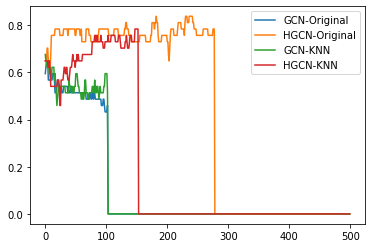

In [20]:
plt.plot(acc_test_gcn_orig, label="GCN-Original")
plt.plot(acc_test_hgcn_orig, label="HGCN-Original")
plt.plot(acc_test_gcn_knn, label="GCN-KNN")
plt.plot(acc_test_hgcn_knn, label="HGCN-KNN")
plt.legend()

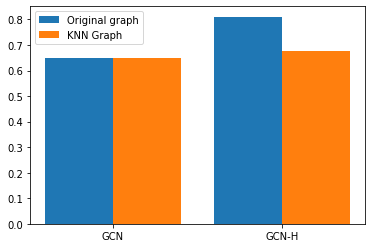

In [21]:
plt.bar(np.arange(2)-0.2, [best_acc_test_gcn_orig, best_acc_test_hgcn_orig], width=0.4)
plt.bar(np.arange(2)+0.2, [best_acc_test_gcn_knn, best_acc_test_hgcn_knn], width=0.4)
plt.xticks(np.arange(2), ["GCN", "GCN-H"])
plt.legend(["Original graph", "KNN Graph"])

# Exhaustive tests

In [22]:
datasets = ['Texas', 'Wisconsin', 'Cornell', 'Actor', 'Chameleon', 'Squirrel']
#datasets = ['Texas', 'Cornell']

In [23]:
EXPS = [
    {
        'leg': 'Original',
        'graph': 'orig'
    },
    {
        'leg': 'KNN-Feats-3',
        'graph': 'knn',
        'feat': 'feats',
        'nneigh': 3
    },
    {
        'leg': 'KNN-Feats-7',
        'graph': 'knn',
        'feat': 'feats',
        'nneigh': 7
    },
    {
        'leg': 'KNN-Role-3',
        'graph': 'knn',
        'feat': 'role',
        'nneigh': 3
    },
    {
        'leg': 'KNN-Role-7',
        'graph': 'knn',
        'feat': 'role',
        'nneigh': 7
    },
    {
        'leg': 'KNN-Global-3',
        'graph': 'knn',
        'feat': 'global',
        'nneigh': 3
    },
    {
        'leg': 'KNN-Global-7',
        'graph': 'knn',
        'feat': 'global',
        'nneigh': 7
    },
    {
        'leg': 'SG-GNN-Node',
        'graph': "adaptive",
        'per_node': True
    },
    {
        'leg': 'SG-GNN',
        'graph': "adaptive",
        'per_node': False
    }
]

In [24]:
# Pre-compute feats
try:
    with open('feats.pkl', 'rb') as f:
        fcontent = pickle.load(f)
    print("Loaded Feats and KNN graphs from cache")
    feats = fcontent['feats']
    knn_graphs = fcontent['knn_graphs']
except FileNotFoundError:
    # Compute feats and store them
    feats = {}
    knn_graphs = {}
    for d, dname in enumerate(datasets):
        print("Starting dataset", dname)

        dataset = eval(dname + 'Dataset')()
        graph = dataset[0]
        A = graph.clone().adj().to_dense().to(device)
        A_np = A.clone().cpu().numpy()
        X = graph.ndata['feat']

        feats[dname] = {}
        knn_graphs[dname] = {}
        for e, exp in enumerate(EXPS):
           
            if exp['graph'] != "knn":
                continue
            
            print(f"Exp {exp['leg']}", flush=True)
            if exp['feat'] in feats[dname]:
                Fr = feats[dname][exp['feat']].copy()
            else:
                if exp['feat'] == 'feats':
                    Fr = X.clone().numpy()
                else:
                    Fr = compute_features(A_np, exp['feat'])
                feats[dname][exp['feat']] = Fr

            A_exp = kneighbors_graph(Fr, exp['nneigh']).todense()

            feats[dname][exp['feat']] = Fr
            knn_graphs[dname][exp['leg']] = A_exp

    with open('feats.pkl', 'wb') as f:
        pickle.dump({'exps': EXPS, 'feats': feats, 'knn_graphs': knn_graphs}, f)

Loaded Feats and KNN graphs from cache


In [ ]:
n_sims = 25

gcn_kwargs = {'norm': 'both'}
hgcn_kwargs = {'S': None, 'K': 3}

best_accs_test = np.zeros((len(datasets), n_sims, 2, len(EXPS)))
smoothness = np.zeros((len(datasets), len(EXPS)-2))
norm_smoothness = np.zeros((len(datasets), len(EXPS)-2))
edge_homophilies = np.zeros((len(datasets), len(EXPS)-2))
node_homophilies = np.zeros((len(datasets), len(EXPS)-2))
tot_var_digraphs = np.zeros((len(datasets), len(EXPS)-2))

graphs = {}
adjs = {}
Ys = {}
learned_coefs = {}

for d, dataset_name in enumerate(datasets):

    print("Starting dataset", dataset_name)
    
    dataset = eval(dataset_name + 'Dataset')()
    assert len(dataset) == 1
    graph = dataset[0]

    N = graph.number_of_nodes()
    n_classes = dataset.num_classes

    X = graph.ndata['feat'].to(device)
    Y = graph.ndata['label'].to(device)
    train_idx = graph.ndata['train_mask'].to(device)
    val_idx = graph.ndata['val_mask'].to(device)
    test_idx = graph.ndata['test_mask'].to(device)

    in_dim = X.shape[1]
    out_dim = n_classes

    A = graph.clone().adj().to_dense().to(device)
    A_np = A.clone().cpu().numpy()

    graphs[dataset_name] = {}
    adjs[dataset_name] = {}
    learned_coefs[dataset_name] = {}
    Ys[dataset_name] = Y.clone().cpu().float()

    for e, exp in enumerate(EXPS):

        print(f"Starting exp {exp['leg']}", end=" - ")

        if exp['graph'] != "adaptive":
            
            if exp['graph'] == "orig":
                g = graph.clone().to(device)
                A_exp = A_np.copy()
            elif exp['graph'] == "knn":
                A_exp = knn_graphs[dataset_name][exp['leg']]
                g = dgl.from_networkx(nx.from_numpy_array(A_exp)).to(device)

            A_exp_torch = torch.from_numpy(A_exp.copy()).to(device).float()
            L = torch.diag(A_exp_torch.sum(1)) - A_exp_torch
            Yf = Y.clone().float()

            smoothness[d,e] = Yf @ L @ Yf
            norm_smoothness[d,e] = Yf @ L @ Yf / (A_exp.sum() // 2)

            norm_S = A_exp_torch / torch.max(torch.abs(torch.linalg.eigvals(A_exp_torch)))
            tot_var_digraphs[d,e] = torch.linalg.norm(Yf - norm_S @ Yf, 1) / N

            edge_homophilies[d,e] = edge_homophily(g, Y)
            node_homophilies[d,e] = node_homophily(g, Y)

            graphs[dataset_name][exp['leg']] = g.clone()
            adjs[dataset_name][exp['leg']] = A_exp_torch.clone()

            g = g.add_self_loop()
        else:
            g_list = list(graphs[dataset_name].values())
            g = [gr.add_self_loop() for gr in g_list]
            n_graphs = len(g)
            As = list(adjs[dataset_name].values())

        for s in range(n_sims):

            print(s+1, end=" ", flush=True)

            if train_idx.ndim > 1:
                idx = s % train_idx.shape[1]
                train_idx_sim = train_idx[:,idx]
                val_idx_sim = val_idx[:,idx]
                test_idx_sim = test_idx[:,idx]
            else:
                train_idx_sim = train_idx
                val_idx_sim = val_idx
                test_idx_sim = test_idx

            if exp['graph'] != "adaptive":

                gcn_model = GCN(in_dim, hid_dim, out_dim, n_layers, nonlin=nonlin, last_act=nn.Identity(), dropout=.25, gcnlayer=dgl.nn.GraphConv, gcnlayer_kwargs=gcn_kwargs).to(device)
                    
                # GCN H
                hgcn_kwargs['S'] = A_exp_torch
                hgcn_model = GCN(in_dim, hid_dim, out_dim, n_layers, nonlin=nonlin, last_act=nn.Softmax(dim=1), dropout=.25, gcnlayer=GCNHLayer, gcnlayer_kwargs=hgcn_kwargs).to(device)
                
            else:
                if exp['per_node']:
                    per_node_val = N
                else:
                    per_node_val = -1
                    
                gcn_model = AdaptiveAggGCN(in_dim, hid_dim, out_dim, n_graphs, nonlin=nonlin, last_act=nn.Identity(), dropout=.25, gcnlayer=dgl.nn.GraphConv, gcnlayer_kwargs=gcn_kwargs, per_node=per_node_val).to(device)

                hgcn_kwargs['S'] = As
                hgcn_model = AdaptiveAggGCN(in_dim, hid_dim, out_dim, n_graphs, nonlin=nonlin, last_act=nn.Softmax(dim=1), dropout=.25, gcnlayer=GCNHLayer, gcnlayer_kwargs=hgcn_kwargs, per_node=per_node_val).to(device)

            loss_train_gcn, acc_train_gcn, acc_val_gcn, acc_test_gcn, best_acc_test_gcn =\
                test(gcn_model, X, Y, train_idx_sim, val_idx_sim, test_idx_sim, g, verbose=False)
            
            best_accs_test[d,s,0,e] = best_acc_test_gcn

            loss_train_hgcn, acc_train_hgcn, acc_val_hgcn, acc_test_hgcn, best_acc_test_hgcn =\
                test(hgcn_model, X, Y, train_idx_sim, val_idx_sim, test_idx_sim, hgcn_kwargs['S'], verbose=False) # In fact the hgcn_kwargs does nothing (supposedly), but it is there for an assert only
            
            best_accs_test[d,s,1,e] = best_acc_test_hgcn
            
            if exp['graph'] == "adaptive":
                learned_coefs[dataset_name][exp['leg']] = [gcn_model.alphas.data.clone().cpu(), hgcn_model.alphas.data.clone().cpu()]
        
        print("DONE")

Starting dataset Texas
Done loading data from cached files.
Starting exp Original - DONE
Starting exp KNN-Feats-3 - DONE
Starting exp KNN-Feats-7 - DONE
Starting exp KNN-Role-3 - DONE
Starting exp KNN-Role-7 - DONE
Starting exp KNN-Global-3 - DONE
Starting exp KNN-Global-7 - DONE
Starting exp SG-GNN-Node - DONE
Starting exp SG-GNN - DONE
Starting dataset Wisconsin
Done loading data from cached files.
Starting exp Original - DONE
Starting exp KNN-Feats-3 - DONE
Starting exp KNN-Feats-7 - DONE
Starting exp KNN-Role-3 - DONE
Starting exp KNN-Role-7 - DONE
Starting exp KNN-Global-3 - DONE
Starting exp KNN-Global-7 - DONE
Starting exp SG-GNN-Node - DONE
Starting exp SG-GNN - DONE
Starting dataset Cornell
Done loading data from cached files.
Starting exp Original - DONE
Starting exp KNN-Feats-3 - DONE
Starting exp KNN-Feats-7 - DONE
Starting exp KNN-Role-3 - DONE
Starting exp KNN-Role-7 - DONE
Starting exp KNN-Global-3 - DONE
Starting exp KNN-Global-7 - DONE
Starting exp SG-GNN-Node - DONE
S

# Results

## Homophily plots

In [26]:
legend = ["Original", "KNN-Feat-3", "KNN-Feat-7", "KNN-Role-3", "KNN-Role-7", "KNN-Global-3", "KNN-Global-7"]
bar_width = 0.1

(0.0, 50000.0)

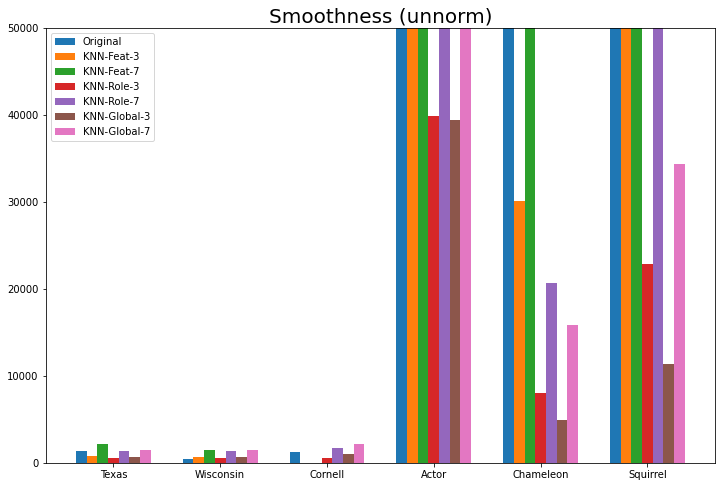

In [27]:
plt.figure(figsize=(12,8))

x_ax = np.arange(len(datasets))
for i in range(smoothness.shape[1]):
    plt.bar(x_ax + i*bar_width, smoothness[:,i], width=bar_width, label=legend[i])

plt.xticks(x_ax + bar_width * (smoothness.shape[1] - 1) / 2, datasets)
plt.title("Smoothness (unnorm)", fontsize=20)
plt.legend()
plt.ylim([0,50000])

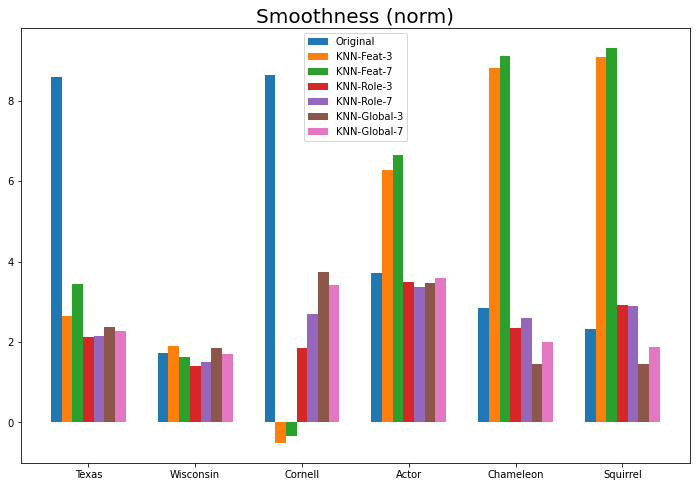

In [28]:
plt.figure(figsize=(12,8))

x_ax = np.arange(len(datasets))
for i in range(norm_smoothness.shape[1]):
    plt.bar(x_ax + i*bar_width, norm_smoothness[:,i], width=bar_width, label=legend[i])

plt.xticks(x_ax + bar_width * (norm_smoothness.shape[1] - 1) / 2, datasets)
plt.title("Smoothness (norm)", fontsize=20)
plt.legend()

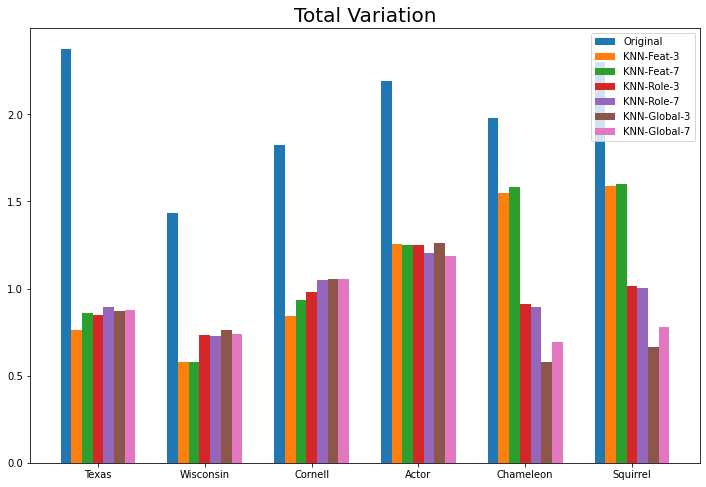

In [29]:
plt.figure(figsize=(12,8))

x_ax = np.arange(len(datasets))
for i in range(tot_var_digraphs.shape[1]):
    plt.bar(x_ax + i*bar_width, tot_var_digraphs[:,i], width=bar_width, label=legend[i])

plt.xticks(x_ax + bar_width * (tot_var_digraphs.shape[1] - 1) / 2, datasets)
plt.title("Total Variation", fontsize=20)
plt.legend()

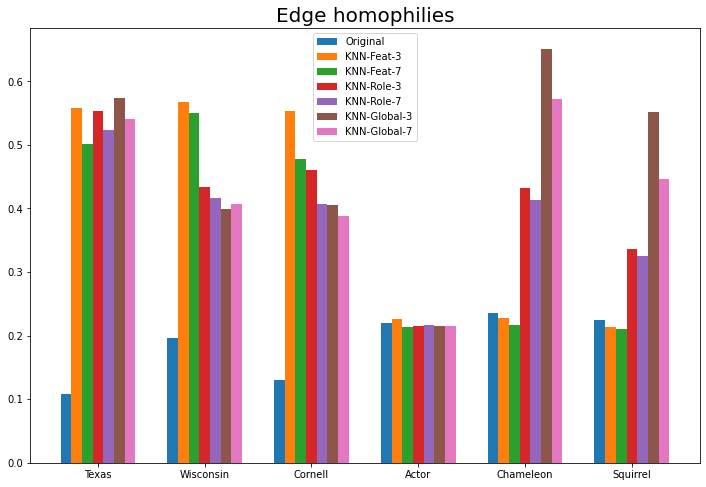

In [30]:
plt.figure(figsize=(12,8))

x_ax = np.arange(len(datasets))
for i in range(edge_homophilies.shape[1]):
    plt.bar(x_ax + i*bar_width, edge_homophilies[:,i], width=bar_width, label=legend[i])

plt.xticks(x_ax + bar_width * (edge_homophilies.shape[1] - 1) / 2, datasets)
plt.title("Edge homophilies", fontsize=20)
plt.legend()
#plt.ylim([0,50000])

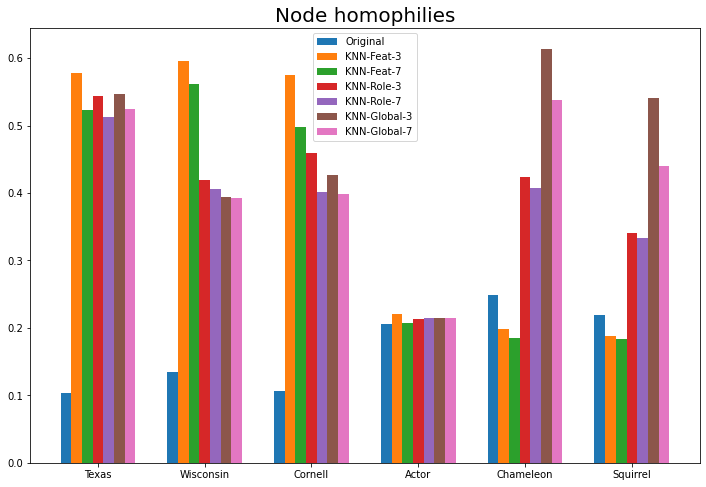

In [31]:
plt.figure(figsize=(12,8))

x_ax = np.arange(len(datasets))
for i in range(node_homophilies.shape[1]):
    plt.bar(x_ax + i*bar_width, node_homophilies[:,i], width=bar_width, label=legend[i])

plt.xticks(x_ax + bar_width * (node_homophilies.shape[1] - 1) / 2, datasets)
plt.title("Node homophilies", fontsize=20)
plt.legend()

In [32]:
import pandas as pd

idxs = [0,1,3,5]

df = pd.DataFrame(tot_var_digraphs[:,idxs], index=datasets, columns=[legend[i] for i in idxs])
print(df.to_latex())

\begin{tabular}{lrrrr}
\toprule
{} &  Original &  KNN-Feat-3 &  KNN-Role-3 &  KNN-Global-3 \\
\midrule
Texas     &  2.377261 &    0.761384 &    0.846998 &      0.870676 \\
Wisconsin &  1.432984 &    0.580346 &    0.731740 &      0.763613 \\
Cornell   &  1.824105 &    0.843352 &    0.981786 &      1.056468 \\
Actor     &  2.192559 &    1.256503 &    1.250266 &      1.261272 \\
Chameleon &  1.976782 &    1.546773 &    0.912755 &      0.578983 \\
Squirrel  &  2.299290 &    1.590335 &    1.017435 &      0.662131 \\
\bottomrule
\end{tabular}



In [33]:
df = pd.DataFrame(edge_homophilies[:,idxs], index=datasets, columns=[legend[i] for i in idxs])
print(df.to_latex())

\begin{tabular}{lrrrr}
\toprule
{} &  Original &  KNN-Feat-3 &  KNN-Role-3 &  KNN-Global-3 \\
\midrule
Texas     &  0.107692 &    0.557836 &    0.553922 &      0.574359 \\
Wisconsin &  0.196117 &    0.567797 &    0.433272 &      0.399232 \\
Cornell   &  0.130872 &    0.552830 &    0.459906 &      0.405063 \\
Actor     &  0.219341 &    0.226190 &    0.214680 &      0.215401 \\
Chameleon &  0.235007 &    0.227978 &    0.431680 &      0.651369 \\
Squirrel  &  0.223943 &    0.213029 &    0.335654 &      0.551077 \\
\bottomrule
\end{tabular}



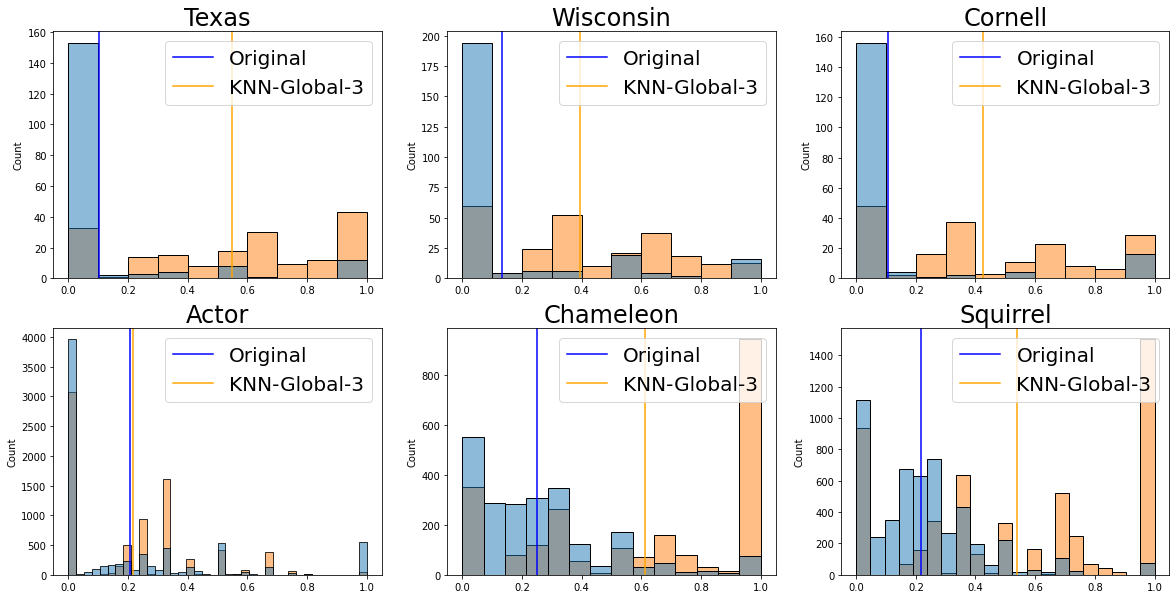

In [36]:
f, ax = plt.subplots(2,len(datasets)//2,figsize=(20,10))

for d, ax in enumerate(ax.ravel()):
    node_homophilies_orig = node_homophily_pernode(graphs[datasets[d]]['Original'].cpu(), Ys[datasets[d]]).numpy()
    node_homophilies_knn = node_homophily_pernode(graphs[datasets[d]]['KNN-Global-3'].cpu(), Ys[datasets[d]]).numpy()

    sns.histplot([node_homophilies_orig,node_homophilies_knn], ax=ax)
    #sns.histplot(, alpha=0.4, color='orange', label="KNN-Global-3", ax=ax)
    ax.axvline(node_homophilies_orig.mean(), color='b')
    ax.axvline(node_homophilies_knn.mean(), color='orange')
    ax.legend(["Original", "KNN-Global-3"], fontsize=20)
    ax.set_title(datasets[d], fontsize=24)
f.savefig('results/node_homophilies.pdf', bbox_inches='tight')

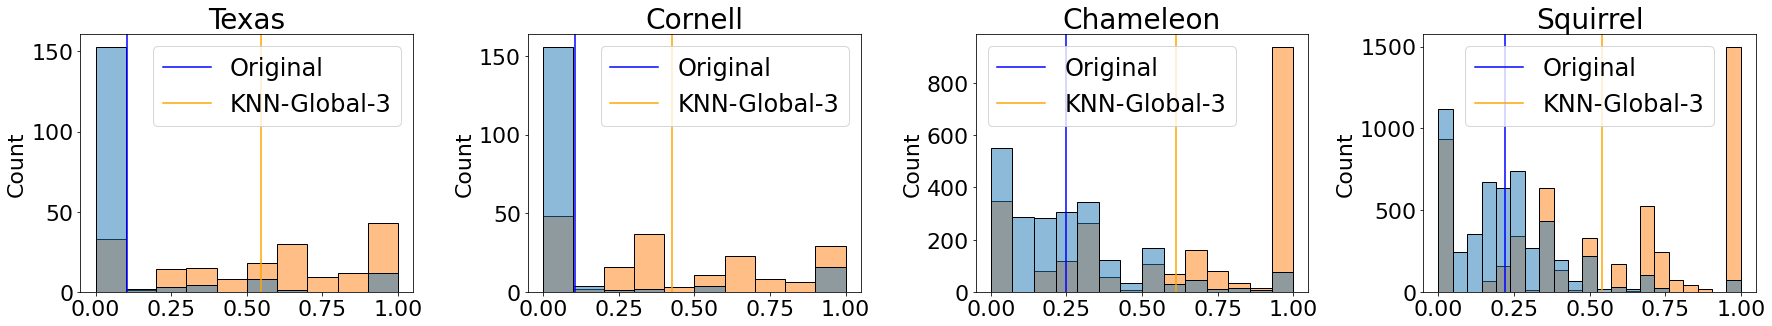

In [46]:
datasets_to_plot = ['Texas', 'Cornell', 'Chameleon', 'Squirrel']

plt.rcParams['font.size'] = 22

f, ax = plt.subplots(1,len(datasets_to_plot),figsize=(25,5))

for d, ax in enumerate(ax.ravel()):
    node_homophilies_orig = node_homophily_pernode(graphs[datasets_to_plot[d]]['Original'].cpu(), Ys[datasets_to_plot[d]]).numpy()
    node_homophilies_knn = node_homophily_pernode(graphs[datasets_to_plot[d]]['KNN-Global-3'].cpu(), Ys[datasets_to_plot[d]]).numpy()

    sns.histplot([node_homophilies_orig,node_homophilies_knn], ax=ax)
    #sns.histplot(, alpha=0.4, color='orange', label="KNN-Global-3", ax=ax)
    ax.axvline(node_homophilies_orig.mean(), color='b')
    ax.axvline(node_homophilies_knn.mean(), color='orange')
    ax.legend(["Original", "KNN-Global-3"], fontsize=24)
    ax.set_title(datasets_to_plot[d], fontsize=28)

plt.tight_layout()
f.savefig('results/node_homophilies.pdf', bbox_inches='tight')

## Accuracy plots

In [ ]:
legend = [exp['leg'] for exp in EXPS]
bar_width = 0.1

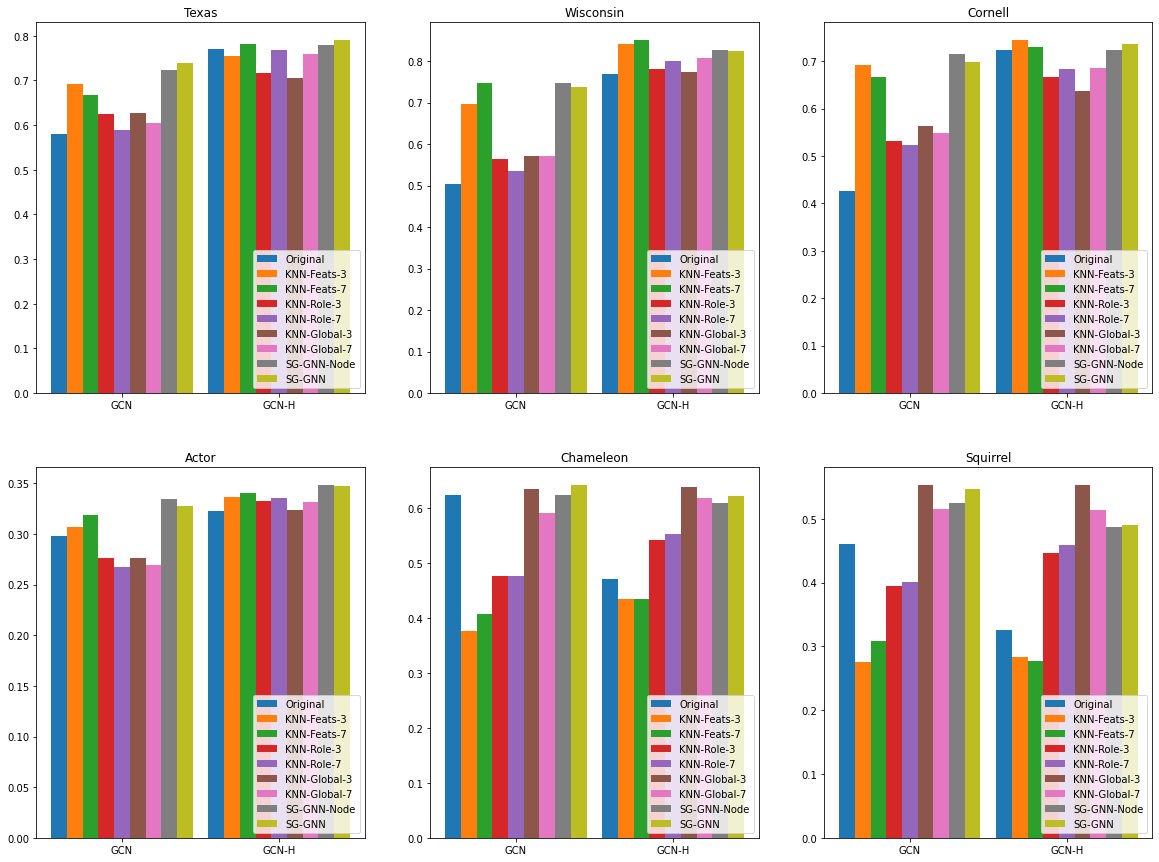

In [ ]:
f, ax = plt.subplots(2,len(datasets)//2,figsize=(20,15))

x_ax = np.arange(2)
num_columns = best_accs_test.shape[-1]

for d, ax in enumerate(ax.ravel()):
    for i in range(num_columns):
        ax.bar(x_ax + i*bar_width, best_accs_test[d,:,:,i].mean(0), width=bar_width, label=legend[i])

    ax.set_xticks(x_ax + bar_width * (num_columns - 1) / 2)
    ax.set_xticklabels(["GCN", "GCN-H"])
    ax.set_title(datasets[d])
    ax.legend(loc="lower right")

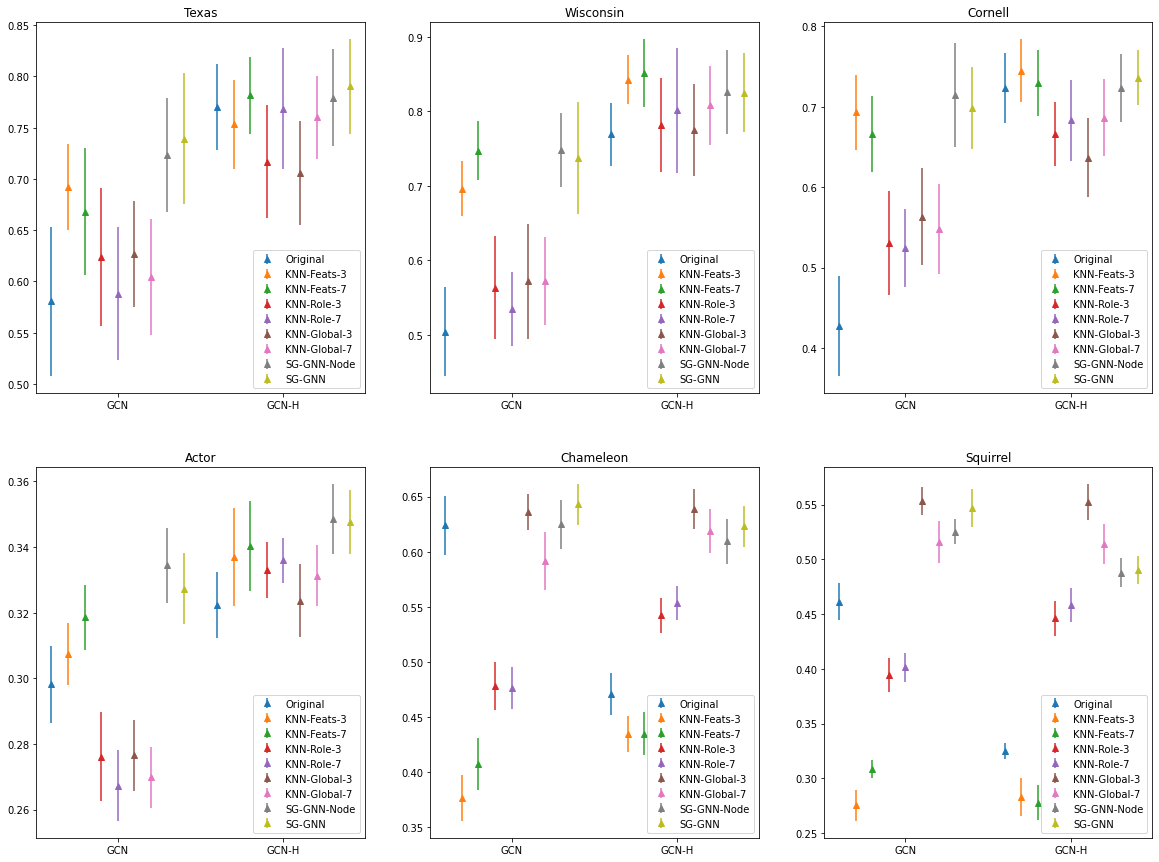

In [ ]:
f, ax = plt.subplots(2,len(datasets)//2,figsize=(20,15))

x_ax = np.arange(2)
num_columns = best_accs_test.shape[-1]

for d, ax in enumerate(ax.ravel()):
    for i in range(num_columns):
        ax.errorbar(x_ax + i*bar_width, best_accs_test[d,:,:,i].mean(0), best_accs_test[d,:,:,i].std(0), linestyle='None', marker='^', label=legend[i])

    ax.set_xticks(x_ax + bar_width * (num_columns - 1) / 2)
    ax.set_xticklabels(["GCN", "GCN-H"])
    ax.set_title(datasets[d])
    ax.legend(loc="lower right")

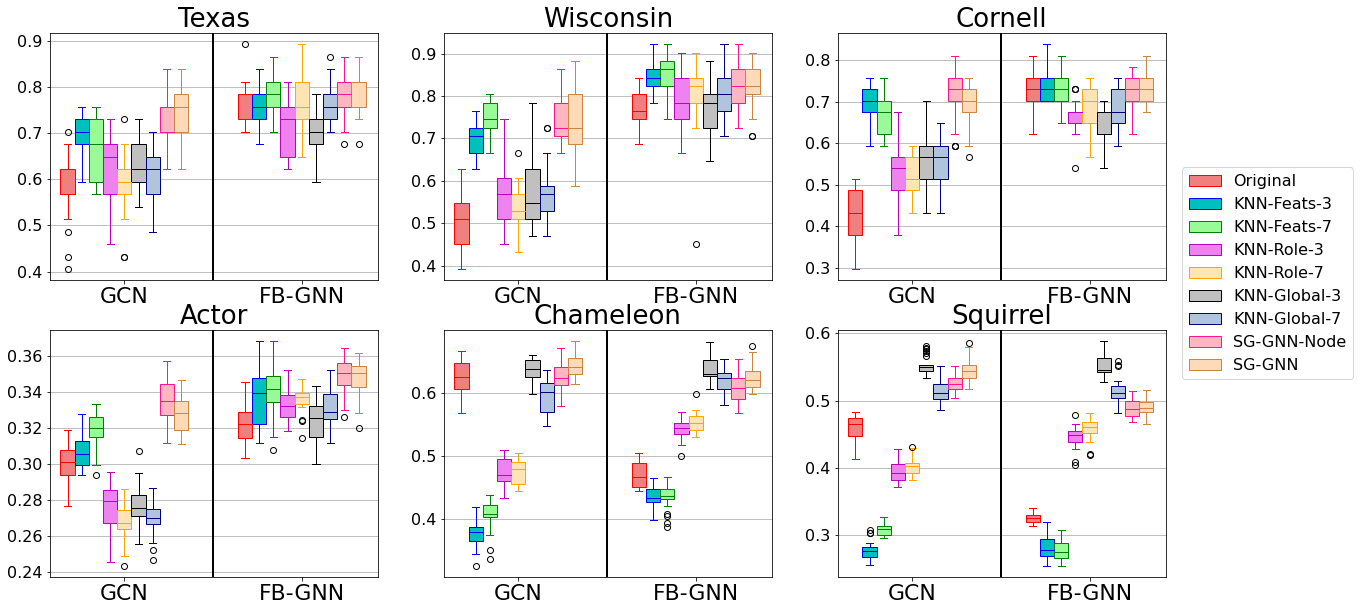

In [ ]:
f, ax = plt.subplots(2,len(datasets)//2,figsize=(20,10))

bar_width = 0.08
x_ax = np.arange(2)
num_columns = best_accs_test.shape[-1]

colors = ['r', 'b', 'g', 'm', 'orange', 'k', 'navy', 'deeppink', 'peru']
fillcolors = ['lightcoral', 'c', 'palegreen', 'violet', 'moccasin', 'silver', 'lightsteelblue', 'lightpink', 'peachpuff']

for d, ax in enumerate(ax.ravel()):
    bps = []
    for i in range(num_columns):
        c = colors[i]
        bp = ax.boxplot(best_accs_test[d,:,:,i], positions=x_ax + i*bar_width, widths=bar_width,
                   patch_artist=True)
            
        for element in ['boxes', 'whiskers', 'fliers', 'means', 'medians', 'caps']:
            plt.setp(bp[element], color=c)

        for patch in bp['boxes']:
            patch.set(facecolor=fillcolors[i])

        bps.append(bp)

    ax.set_xticks(x_ax + bar_width * (num_columns - 1) / 2)
    ax.set_xticklabels(["GCN", "FB-GNN"], fontsize=22)
    ax.set_title(datasets[d], fontsize=26)
    ax.axvline(0.82, color='k', linewidth=2)
    ax.grid(axis='y')
    ax.set_xlim(-0.1,1.75)
    ax.tick_params(axis='y', which='major', labelsize=16)
ax.legend([bps[i]["boxes"][0] for i in range(len(bps))], legend, bbox_to_anchor=(1.05, 0.8), loc='lower left', borderaxespad=0., fontsize=16)
f.savefig('results/knngraph.pdf', bbox_inches='tight')

## Analysis of learned coefficients

In [ ]:
gnames = ["Original", "KNN-Feat-3", "KNN-Feat-7", "KNN-Role-3", "KNN-Role-7", "KNN-Global-3", "KNN-Global-7"]

In [ ]:
learned_coefs_plot = np.zeros((2,len(datasets), n_graphs))

for d, dname in enumerate(datasets):
    learned_coefs_plot[0,d,:] = torch.softmax(learned_coefs[dname]['AdaptiveAgg'][0], 0).numpy()
    learned_coefs_plot[1,d,:] = torch.softmax(learned_coefs[dname]['AdaptiveAgg'][1], 0).numpy()

Text(0.5, 1.0, 'Learned coefs for GCN')

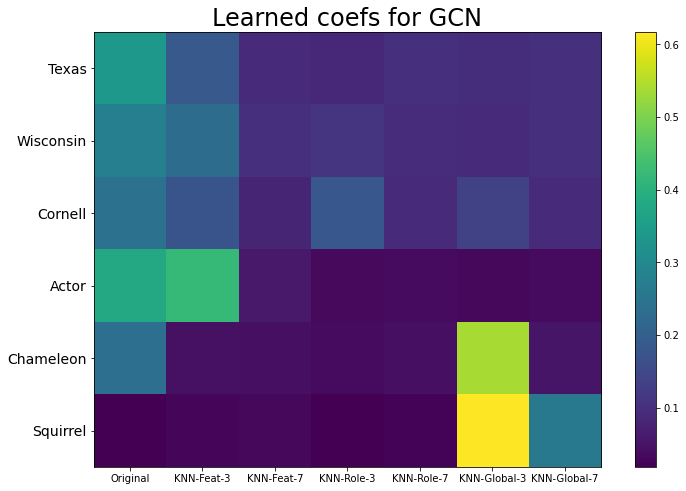

In [ ]:
# No per node
plt.figure(figsize=(12,8))
plt.imshow(learned_coefs_plot[0,:,:])
plt.colorbar()
plt.yticks(np.arange(len(datasets)), datasets, fontsize=14)
plt.xticks(np.arange(n_graphs), gnames, fontsize=10)
plt.title("Learned coefs for GCN", fontsize=24)

Text(0.5, 1.0, 'Learned coefs for GCNH')

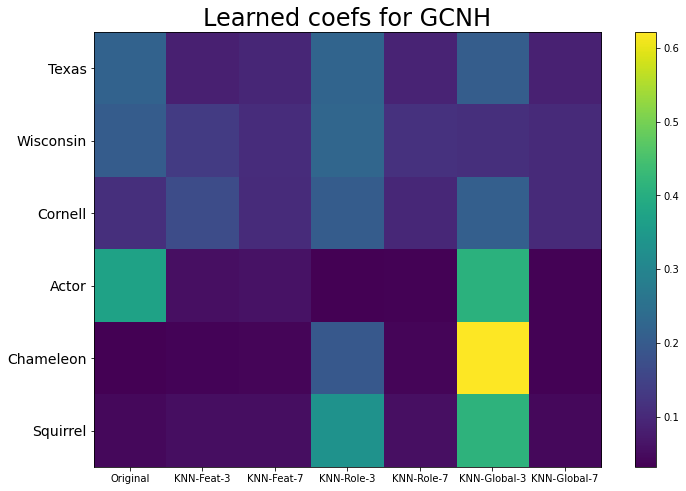

In [ ]:
# No per node
plt.figure(figsize=(12,8))
plt.imshow(learned_coefs_plot[1,:,:])
plt.colorbar()
plt.yticks(np.arange(len(datasets)), datasets, fontsize=14)
plt.xticks(np.arange(n_graphs), gnames, fontsize=10)
plt.title("Learned coefs for GCNH", fontsize=24)

<AxesSubplot:>

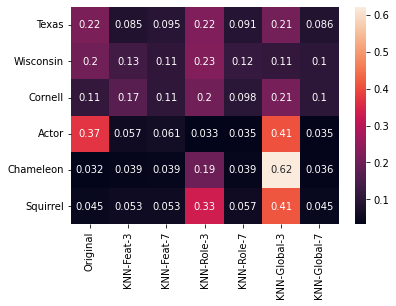

In [ ]:
import seaborn as sns

sns.heatmap(learned_coefs_plot[1,:,:], annot=True, xticklabels=gnames, yticklabels=datasets)

In [ ]:
# For PGF-Plots
for i in range(2):
    with open(f"results/coefs-{'GCN' if i == 0 else 'GCNH'}.csv", 'w') as f:
        f.write("x y value\n")
        for j in range(learned_coefs_plot.shape[1]):
            for k in range(learned_coefs_plot.shape[2]):
                f.write(f"{k} {j} {learned_coefs_plot[i,j,k]}\n")

Text(0.5, 1.0, 'Learned coefs for GCN')

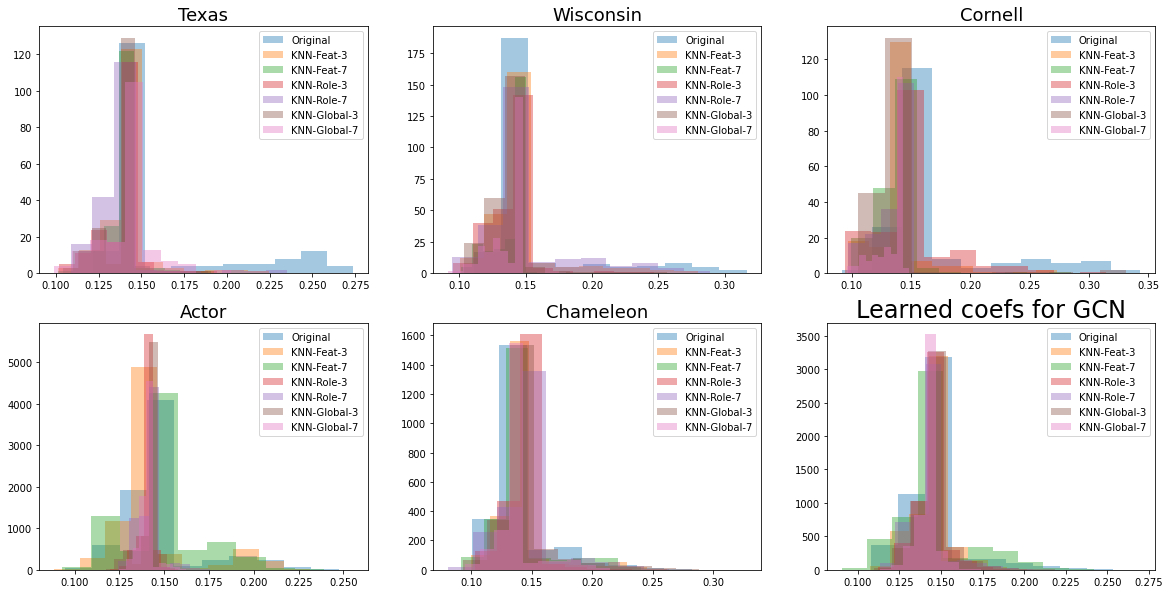

In [ ]:
# Per node
f, ax = plt.subplots(2,len(datasets)//2,figsize=(20,10))

for d, ax in enumerate(ax.ravel()):
    coefs = torch.softmax(learned_coefs[datasets[d]]['AdaptiveAgg-perNode'][0], dim=0).numpy()
    for ng in range(n_graphs):
        ax.hist(coefs[ng,:], alpha=0.4, label=gnames[ng])
    ax.legend(fontsize=10)
    ax.set_title(datasets[d], fontsize=18)

plt.title("Learned coefs for GCN", fontsize=24)